# IP 3: Predicting production and attraction of zones based on POI's and population density with an xgBoost model


In [ ]:
# Install the packages that are not yet installed of the next block of code
# pip install xgboost
# pip install ...

In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import xgboost as xgb
import shap
import seaborn as sns

## Read files

The following datasets are required in this file:
1) combined_data_ALL_TRAIN.shp: training dataset generated with file 'combine_data'
2) combined_data_ALL_TEST.shp: test dataset generated with file 'combine_data'
3) ZONERING_spm_VLA.shp : zonering of MOW 

 They have the following characteristics:
- The train data have in total 193 zones from the city 'ANTWERPEN'.
- The test data have in total 217 zones from the cities 'GENT', 'DENDERMONDE', 'BEVEREN' and 'HASSELT'.

In [2]:
setup_params = {'user': 'L', 'target': 'attraction', 'logtrans': 1, 'outlier': 0, 'CV': 1}

# User: choose the user. This will make sure the right directory is chosen to load and read files: 'E' or 'L'  ('E': Emma & 'L': Laurens)
# logtrans: do you want to apply a logarithmic transformation? 1 for yes, 0 for no
# outlier: want to perform outlier detection? 1 for yes, 0 for no
# CV = Cross validation: do you want to select hyperparameters based on cross validation or standard parameters for XGBoost? 1 for yes, 0 for no

In [3]:
name_model = "attr_small_model.json"                     # The name with which the model will be saved
name_excel_file_metrics = "Metrics_ATTR_small_model"     # The name of the excel file in which a summary of the metrics wiil be stored   

In [4]:
#Load in correct files
if setup_params['user'] == 'L': # directories of Laurens
    data_train = gpd.read_file('combined_data\Data_combined\combined_data_ALL_TRAIN.shp')
    data_test = gpd.read_file('combined_data\Data_combined\combined_data_ALL_TEST.shp')
    zones_city = gpd.read_file("OneDrive_2024-03-21\IP3 Emma en Laurens\ZONERING_spm_VLA.shp")  #load in zones of vlaanderen of the MOW data
    print("Laurens")

elif setup_params['user'] == 'E': # directories of Emma
    data_train = gpd.read_file('Data_combined\combined_data_ALL_TRAIN.shp')
    data_test = gpd.read_file('Data_combined\combined_data_ALL_TEST.shp')
    zones_city = gpd.read_file("ZONERING_spm_VLA\ZONERING_spm_VLA.shp")
    print("Emma")


Laurens


## Combined dataset

Summary of the information in the combined dataset:

An important part of this project is the creation of a dataset. The dataset used includes the production and attraction of displacements between 7am and 8am for each zone, the POI information and population information for each zone. For each zone, the POIs are classified into one of the following categories: large_resi, small_resi, School, Health, Leisure, Shops, Services, Industry, Catering_i, Tourism, leisure_ar and Other. In addition, each zone has a zone number and the geometry of a zone is stored by means of a polygon. In addition, the number of inhabitants and population density is also known (calculation see file "Density_inw_per_ha"). The name of the city where the zone is located is also explicitly given. Finally, the size of the city is added, giving an estimate of approximately how many inhabitants live in the city. This can be used as information for the model and shows to which category the city has been counted.

In [5]:
data_train = data_train[data_train['city'] == 'ANTWERPEN']

In [6]:
# Shows how the dataframe 
data_train.head()

,ZONENUMMER,inhabitant,density,city,city_size,production,attraction,large_resi,small_resi,School,Health,Leisure,Shops,Services,Industry,Catering_i,Tourism,Others,Leisure_ar,geometry
0,8,2852.592124,10338.533007,ANTWERPEN,500000,591.711,809.713,78568.365178,2629.949173,3240.647711,128.442093,1148.359176,5944.020433,5759.299732,0.0,13115.489042,5320.593807,4607.435937,439.452869,"POLYGON ((151886.893 212393.727, 151896.819 21..."
1,9,1663.206665,12061.589962,ANTWERPEN,500000,377.687,1077.690,54593.025088,11163.096491,0.000000,513.009998,399.359237,2160.485684,7866.468777,0.0,2653.671133,408.952544,0.000000,0.000000,"POLYGON ((152291.417 213076.701, 152323.130 21..."
2,10,540.996256,4973.824681,ANTWERPEN,500000,233.434,1331.431,37052.473093,200.381735,2361.870653,556.902082,631.059088,19381.985231,3327.157104,0.0,7229.002237,348.766092,7445.807094,0.000000,"POLYGON ((152554.784 212236.842, 152554.655 21..."
3,11,1118.253264,12097.422044,ANTWERPEN,500000,264.410,230.412,37097.357794,628.217699,0.000000,109.942887,921.972837,8507.389210,1569.489492,0.0,12445.166200,2814.945431,0.000000,363.209287,"POLYGON ((151952.251 212369.105, 152001.366 21..."
4,12,1353.762508,9070.177277,ANTWERPEN,500000,355.119,1851.122,46076.192553,910.223994,11400.031400,307.276028,3009.474225,17572.225446,10773.263095,0.0,3064.863207,354.988740,4123.672896,332.580263,"POLYGON ((152461.194 211945.115, 152467.897 21..."


In [7]:
# Overvieuw of the data 
data_train.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 193 entries, 0 to 192
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   ZONENUMMER  193 non-null    object  
 1   inhabitant  193 non-null    float64 
 2   density     193 non-null    float64 
 3   city        193 non-null    object  
 4   city_size   193 non-null    int64   
 5   production  193 non-null    float64 
 6   attraction  193 non-null    float64 
 7   large_resi  193 non-null    float64 
 8   small_resi  193 non-null    float64 
 9   School      193 non-null    float64 
 10  Health      193 non-null    float64 
 11  Leisure     193 non-null    float64 
 12  Shops       193 non-null    float64 
 13  Services    193 non-null    float64 
 14  Industry    193 non-null    float64 
 15  Catering_i  193 non-null    float64 
 16  Tourism     193 non-null    float64 
 17  Others      193 non-null    float64 
 18  Leisure_ar  193 non-null    float64 
 19  

In [8]:
# Gives an insight into the values of the numeric columns
data_train.describe()

# Note that some of the categories of the POIs have over 50% of zeros.

,inhabitant,density,city_size,production,attraction,large_resi,small_resi,School,Health,Leisure,Shops,Services,Industry,Catering_i,Tourism,Others,Leisure_ar
count,193.000000,193.000000,193.0,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,193.000000,1.930000e+02
mean,2686.651997,7075.350665,500000.0,559.502166,671.201746,25105.338035,43824.622632,3537.041619,1360.168770,1883.416164,4989.504688,3742.045714,9499.320126,1112.175077,660.375486,819.159737,5.454023e+04
std,2208.313836,6583.836039,0.0,456.780468,541.618238,39615.334629,59049.779342,6091.656184,3656.648726,4704.208417,9395.277150,6148.693934,37012.859175,2069.374473,2013.349233,1771.373323,1.787480e+05
min,0.000000,0.000000,500000.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,427.022433,671.593515,500000.0,108.037000,203.492000,0.000000,138.893466,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
50%,2428.645122,6141.914569,500000.0,537.090000,554.845000,1524.787810,4174.716186,1410.294867,142.609778,191.433307,1945.961216,866.204284,0.000000,312.906169,0.000000,0.000000,1.664999e+03
75%,4367.002662,11219.669361,500000.0,877.811000,1033.104000,37271.177256,85063.928204,4801.834964,756.026551,1510.006413,6323.855530,5100.337185,418.009253,1139.175937,209.292301,1264.127690,2.580218e+04
max,8106.342111,24408.190046,500000.0,2029.289000,3338.480000,166332.504250,232766.052055,44900.671729,26017.265470,40384.007551,81972.336248,32097.316653,279850.021282,13115.489042,19529.619899,19119.617359,1.561546e+06


In [9]:
# Shows the cities used in the training set
data_train['city'].unique() 

array(['ANTWERPEN'], dtype=object)

In [10]:
# Shows what the dataframe 
data_test.head()

,ZONENUMMER,inhabitant,density,city,city_size,production,attraction,large_resi,small_resi,School,Health,Leisure,Shops,Services,Industry,Catering_i,Tourism,Others,Leisure_ar,geometry
0,2467,804.273060,3954.691868,GENT,270000,252.865,965.871,3682.170215,50511.095518,7132.437994,166.118609,3909.543358,16250.966143,14390.828625,0.000000,17049.292734,6532.082039,10895.960539,3465.859923,"POLYGON ((105184.260 193832.897, 105175.236 19..."
1,2468,2717.092743,8733.092072,GENT,270000,770.022,1595.021,7514.938419,117408.020203,13887.516715,598.349485,2944.023268,9283.314743,20233.002534,1987.422401,8153.527634,3275.916877,1435.731971,19413.533645,"POLYGON ((105410.629 194259.208, 105429.192 19..."
2,2469,1147.842147,4772.002629,GENT,270000,531.773,2015.771,24719.747133,38110.237909,7342.780263,221.602732,4094.486782,35844.719439,20704.937687,0.000000,10505.158643,3981.695294,500.949986,0.000000,"POLYGON ((105094.151 193691.739, 105073.654 19..."
3,2470,879.090943,8459.200304,GENT,270000,245.520,170.511,7645.839036,35345.222585,0.000000,346.997186,92.178082,1662.331753,1498.794963,0.000000,7764.661214,4133.462087,0.000000,1879.121492,"POLYGON ((104839.808 194650.326, 104838.648 19..."
4,2471,2332.238767,6067.689094,GENT,270000,500.952,1263.949,16358.827533,44831.573405,4927.202098,39243.558808,4388.634171,2738.776977,11399.718562,7477.079249,704.467549,3080.305046,6771.232255,48218.319956,"POLYGON ((104839.808 194650.326, 104771.356 19..."


In [11]:
# Overvieuw of the data 
data_test.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 217 entries, 0 to 216
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   ZONENUMMER  217 non-null    object  
 1   inhabitant  217 non-null    float64 
 2   density     217 non-null    float64 
 3   city        217 non-null    object  
 4   city_size   217 non-null    int64   
 5   production  217 non-null    float64 
 6   attraction  217 non-null    float64 
 7   large_resi  217 non-null    float64 
 8   small_resi  217 non-null    float64 
 9   School      217 non-null    float64 
 10  Health      217 non-null    float64 
 11  Leisure     217 non-null    float64 
 12  Shops       217 non-null    float64 
 13  Services    217 non-null    float64 
 14  Industry    217 non-null    float64 
 15  Catering_i  217 non-null    float64 
 16  Tourism     217 non-null    float64 
 17  Others      217 non-null    float64 
 18  Leisure_ar  217 non-null    float64 
 19  

In [12]:
# Gives an insight into the values of the numeric columns
data_test.describe()

# Note that some of the categories of the POIs have over 50% of zeros.

,inhabitant,density,city_size,production,attraction,large_resi,small_resi,School,Health,Leisure,Shops,Services,Industry,Catering_i,Tourism,Others,Leisure_ar
count,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,2.170000e+02
mean,1953.542940,2434.417987,172442.396313,450.723673,564.986295,7910.219880,85883.262174,5250.610277,2245.362899,2420.375053,6878.185787,7249.584748,40319.855500,1175.746844,1005.609342,679.377192,5.513200e+04
std,1907.843117,3116.393799,105246.745572,460.251155,636.503094,14824.863494,94728.885707,9501.797318,7343.163112,5435.821515,10655.710089,10759.150632,96858.210088,2168.026294,3967.132228,1300.220925,1.285242e+05
min,0.000000,0.000000,50000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00
25%,104.233716,84.999214,50000.000000,31.479000,88.117000,0.000000,3300.067507,0.000000,0.000000,0.000000,0.000000,146.625383,0.000000,0.000000,0.000000,0.000000,0.000000e+00
50%,1478.589540,711.354042,270000.000000,329.749000,360.844000,1525.927271,54024.115408,1465.809542,114.619606,449.937000,2439.071020,3563.523622,2199.457617,357.164869,0.000000,0.000000,1.229601e+04
75%,3165.949338,4325.915397,270000.000000,734.916000,827.636000,7976.153658,127391.866379,6111.688037,1448.978119,3048.112899,8732.308170,10594.206951,21720.013717,1385.276613,448.520813,888.825144,5.606886e+04
max,8066.505314,17290.251960,270000.000000,2385.412000,4339.417000,105282.658123,438684.848324,67178.288971,84135.815336,53943.654883,69801.906357,88293.414112,618122.769860,17049.292734,51891.023282,10895.960539,1.336151e+06


In [13]:
# Shows the cities used in the training set
data_test['city'].unique() 

array(['GENT', 'DENDERMONDE', 'BEVEREN', 'HASSELT'], dtype=object)

# Preprocessing

## Split train/validation/test data

Firstly the target variable is split from the features. Later 20% of the training set is separated and will be used as a validation set. 

In [14]:
# Get the 2 target variables out of the dataframe

# Training set
y_train = data_train[setup_params['target']]
X_train = data_train.drop(columns=['production', 'attraction'])

# Test set
y_test = data_test[setup_params['target']]
X_test = data_test.drop(columns=['production', 'attraction'])

In [15]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets (80%/20%)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Copy the full datasets that havsn't been preprocessed. This will be used later to be able to use the data from the deleted columns when interpreting.
X_train_with_all_columns = X_train.copy()
X_val_with_all_columns = X_val.copy()
X_test_with_all_columns = X_test.copy()

In [16]:
# Drop the features that does not provide valuable information for the predictive model

# Drop the columns from the train DataFrame
X_train.drop(columns=['ZONENUMMER'], inplace=True)
X_train.drop(columns=['geometry'], inplace=True)
X_train.drop(columns=['city'], inplace=True)

# Drop the columns from the validation DataFrame
X_val.drop(columns=['ZONENUMMER'], inplace=True)
X_val.drop(columns=['geometry'], inplace=True)
X_val.drop(columns=['city'], inplace=True)

# Drop the columns from the test DataFrame
X_test.drop(columns=['ZONENUMMER'], inplace=True)
X_test.drop(columns=['geometry'], inplace=True)
X_test.drop(columns=['city'], inplace=True)

## Feature selection

This paragraph will do feature selection based on the correlation matrix of the training dataset and the mutual information between the features and the target variable.


Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior


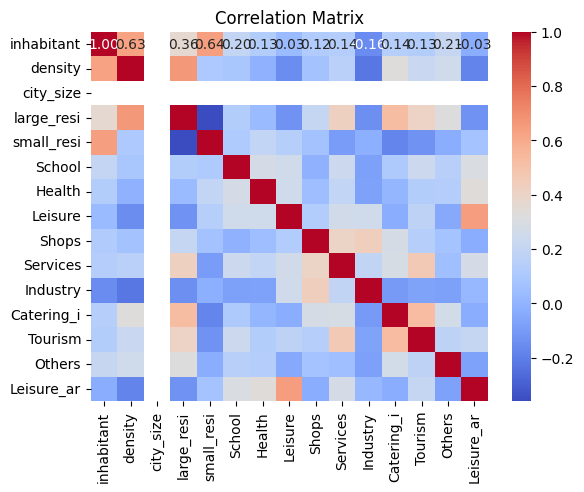

In [17]:
# Check correlation matrix
correlation_matrix = X_train.corr()

# Visualize the correlation matrix
plt.figure()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [18]:
#check for pairs with a high correlation
corr_treshold = 0.5 #set correlation treshold at 0.5

high_correlation_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > corr_treshold: 
            high_correlation_pairs.append((correlation_matrix.columns[i], correlation_matrix.columns[j], str(int(100*abs(correlation_matrix.iloc[i, j])))+'%'))
            

print(high_correlation_pairs)
# High correlation between density & large_res --> drop large_res

[('inhabitant', 'density', '63%'), ('inhabitant', 'small_resi', '63%'), ('density', 'large_resi', '66%'), ('large_resi', 'Catering_i', '52%'), ('Leisure', 'Leisure_ar', '64%'), ('Catering_i', 'Tourism', '52%')]


The correlation matrix shows 6 pairs with a correlation higher than 50%. However, for this project we want to feed the model data that is preprocessed in the same way. That's why only Large_resi will be dropped. The biggest correlation pair and the feature with the lowest mutual info is still eliminated.


In [19]:
from sklearn.feature_selection import mutual_info_regression

# Calculate the mutual info between the target variable 
mutual_info = mutual_info_regression(X_train, y_train)

# Display mutual information scores for each feature
for i, col in enumerate(X_train):  # Exclude the target variable
    print(f"Mutual Information with '{col}': {mutual_info[i]}")

Mutual Information with 'inhabitant': 0.4108384394913087
Mutual Information with 'density': 0.4023779874433613
Mutual Information with 'city_size': 0.0
Mutual Information with 'large_resi': 0.16004633863546625
Mutual Information with 'small_resi': 0.20890093845107005
Mutual Information with 'School': 0.25190564769996326
Mutual Information with 'Health': 0.1454168359006267
Mutual Information with 'Leisure': 0.12030536706726558
Mutual Information with 'Shops': 0.2232063160848945
Mutual Information with 'Services': 0.13279900304046555
Mutual Information with 'Industry': 0.0
Mutual Information with 'Catering_i': 0.2888198806720066
Mutual Information with 'Tourism': 0.07852852833395718
Mutual Information with 'Others': 0.15588620528145158
Mutual Information with 'Leisure_ar': 0.044596804420165226


Density and inhabitant have a high mutual information of 0.66 towards each other. Like said before, both features will remain to have the same pipeline over all the models.

In [20]:

mutual_info = mutual_info_regression(X_train['density'].values.reshape(-1, 1), X_train['inhabitant'].values)
print(mutual_info)

mutual_info = mutual_info_regression(X_train['inhabitant'].values.reshape(-1, 1), X_train['density'].values)
print(mutual_info)

# mutual_info = mutual_info_regression(X_train, X_train['density'].values)
# Display mutual information scores for each feature
# for i, col in enumerate(X_train):  # Exclude the target variable
#    print(f"Mutual Information with '{col}': {mutual_info[i]}")

[0.66043267]
[0.67140527]


In [21]:
# Drop large_res based on correlation and lower mutual information. Don't drop inhabitant as it has high mutual information.
X_train = X_train.drop(columns=['large_resi', 'city_size'])
X_val = X_val.drop(columns=['large_resi', 'city_size'])
X_test = X_test.drop(columns=['large_resi', 'city_size'])

## Log transfromation

As seen on the histogram below the POI data is very imbalanced and always right-skewed. To improve the data quality a log transformation will be applied. This transformation is used because the POI data is always non-negative and it leads to a more normal distribution for the features. Most of the zones have either 0 or a very low value for a POI feature. The log transformation will try to balance the data and get to a normal distribution for the number of POI's throughout the zones. To avoid log(0) a constant is added. 
Later on, the predictions will be backtransformed to make sure they are interpretable.

array([[<Axes: title={'center': 'inhabitant'}>,
        <Axes: title={'center': 'density'}>,
        <Axes: title={'center': 'small_resi'}>,
        <Axes: title={'center': 'School'}>],
       [<Axes: title={'center': 'Health'}>,
        <Axes: title={'center': 'Leisure'}>,
        <Axes: title={'center': 'Shops'}>,
        <Axes: title={'center': 'Services'}>],
       [<Axes: title={'center': 'Industry'}>,
        <Axes: title={'center': 'Catering_i'}>,
        <Axes: title={'center': 'Tourism'}>,
        <Axes: title={'center': 'Others'}>],
       [<Axes: title={'center': 'Leisure_ar'}>, <Axes: >, <Axes: >,
        <Axes: >]], dtype=object)

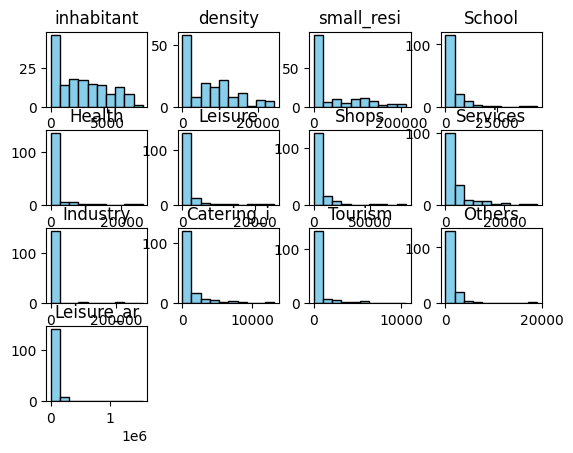

In [22]:
# Show the distribution of the untransformed variables
X_train.hist(color='skyblue', edgecolor='black', grid=False)

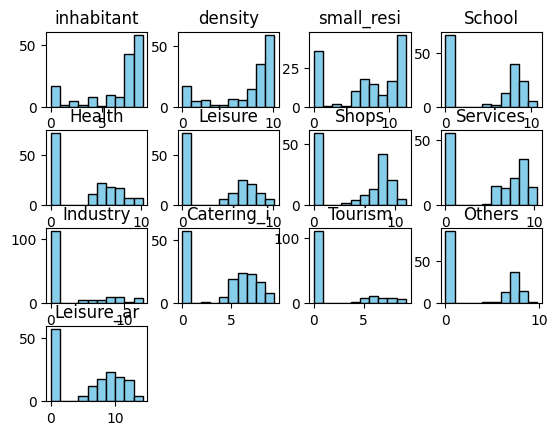

In [23]:
## apply log transformation
if setup_params['logtrans'] == 1:
    X_train = X_train.apply(lambda x: np.log(x + 1))  # Adding 1 to avoid log(0)
    X_val = X_val.apply(lambda x: np.log(x + 1))  
    X_test = X_test.apply(lambda x: np.log(x + 1))  
    X_train.hist(color='skyblue', edgecolor='black', grid=False) # Show the distribution of the Logtransformed variables
    
    y_train = y_train.apply(lambda x: np.log(x + 1))  # Adding 1 to avoid log(0)
    y_val = y_val.apply(lambda x: np.log(x + 1)) 

else:
    print("no log transfromation has been done")

## Outlier detection

The following paragraph creates boxplots for the numerical features. It shows that for the POI features no outliers are found. Inhabitant and density have outliers. This is a consequence of the log transformation. Because of the strong transformation the right skewed data became left skewed. However these outliers won't be taken out for two reasons: Firstly, our dataset is very limited. Secondly, both features were added later on and are perfectly valid instances. It can be interesting to see how the model handles these instances. 

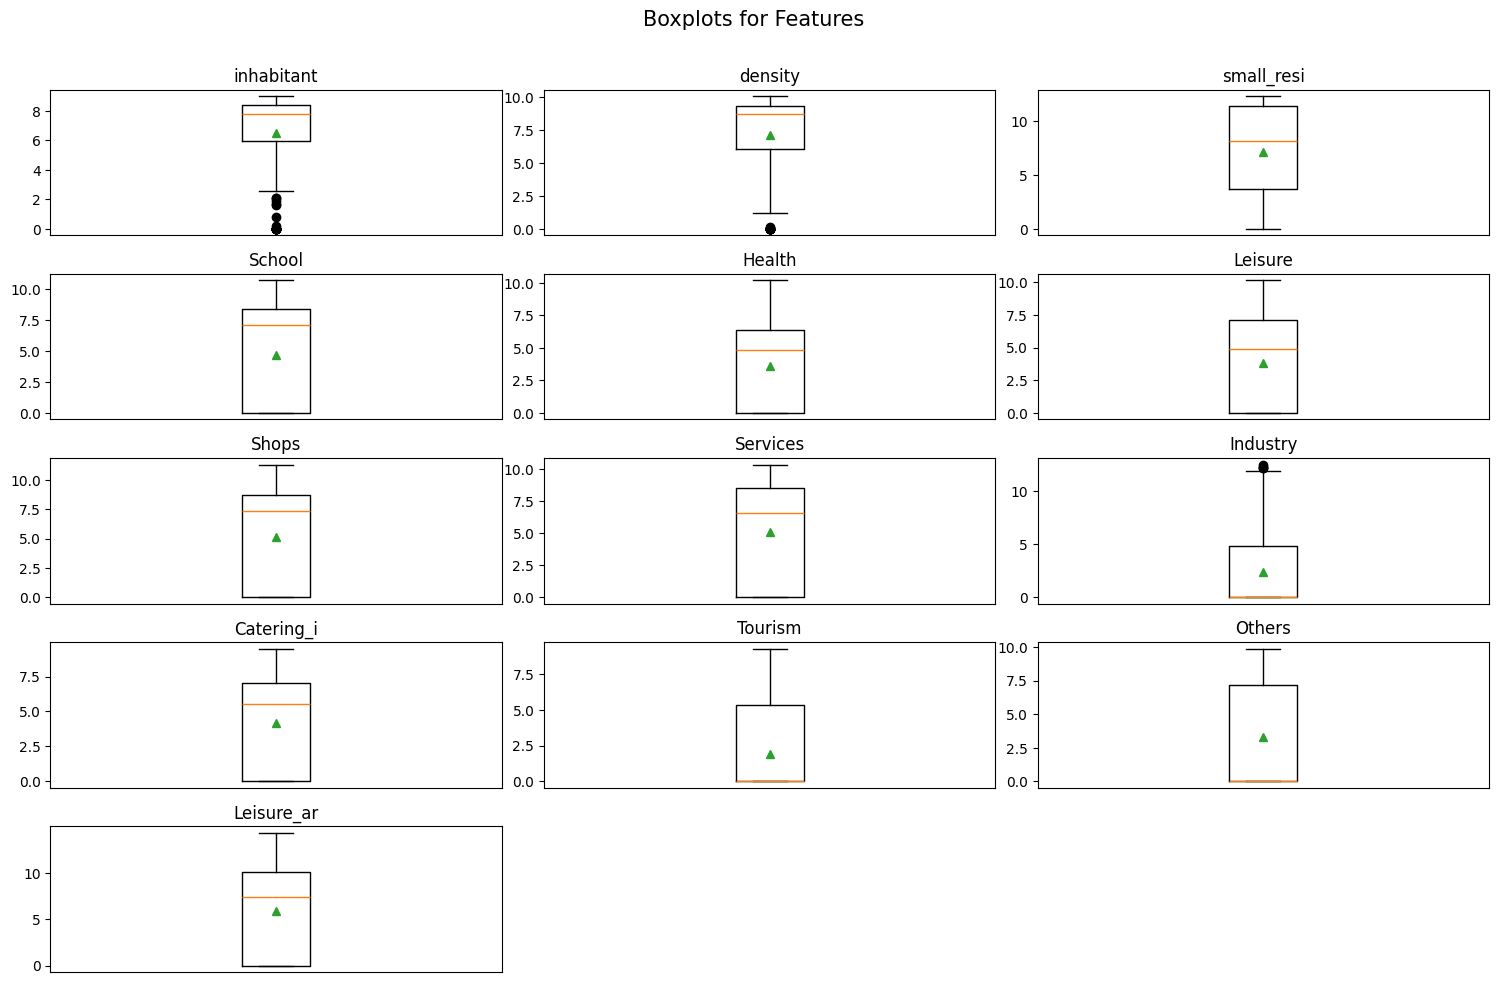

In [24]:
num_features = len(X_train.columns)
num_cols = 3
num_rows = (num_features + num_cols - 1) // num_cols
flierprops = dict(marker='o', markerfacecolor='black')

# create the figures
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
fig.suptitle("Boxplots for Features", fontsize=15)

# flatten the axes array to easily iterate through the subplots
axes = axes.flatten()

for i, feature in enumerate(X_train.columns):
    ax = axes[i]
    ax.boxplot(X_train[feature], showmeans=True, flierprops=flierprops)
    ax.set_title(feature)
    ax.get_xaxis().set_visible(False)

# hide subplots not being used
for i in range(len(X_train.columns), num_rows * num_cols):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

## Metrics overview function

Here two functions are defined to evaluate the models that are created later. The following metrics are used: true mean, pred_mean, bias, MAE, MSE, RMSE, MAPE, uncentered R^2.
The MAPE gives very high values because of small true values or when the absolute value of the difference between the true and the predicted value is large.


In [25]:
def uncentered_r2_score(true, pred):
    SS_res = np.sum((true - pred) ** 2)
    SS_tot = np.sum((true - np.mean(true)) ** 2)
    return 1 - (SS_res / SS_tot)

In [26]:
def metrics_overview(true_value, predicted_value, printing = True):
    
    metrics_all = []

    added_df = pd.DataFrame()
    added_df['predicted'] = list(predicted_value)
    added_df['value'] = list(true_value)
    
    total = added_df['value'].sum()

    intervals = [(0,250),(250,500),(500,750), (750,1000), (1000,1250),(1250,1500), (1500,1750), (1750, 3000),(3000,4500), (0,4500)]

    for interval_start, interval_end in intervals:
        interval = (interval_start, interval_end)
        interval_df = added_df[(added_df['value'] >= interval_start) & (added_df['value'] < interval_end)]

        if not interval_df.empty:
            true = interval_df['value']
            pred = interval_df['predicted']
            
            nr_zones = true.shape[0] 
            percentage_of_total = true.sum()/total
            true_mean = np.mean(true)
            pred_mean = np.mean(pred)
            bias = pred_mean - true_mean
            MAE = metrics.mean_absolute_error(true, pred)
            MSE = metrics.mean_squared_error(true, pred)
            RMSE = np.sqrt(metrics.mean_squared_error(true, pred))
            MAPE = metrics.mean_absolute_percentage_error(true, pred) #can be very high because of small true or when abs(true -  pred) is large
            uncentered_r2 = uncentered_r2_score(true, pred) #metrics.r2_score(true, pred)
        
        else:   #empty inteval_df
            nr_zones = 0
            percentage_of_total = 0
            true_mean = 0
            pred_mean = 0
            bias = 0
            MAE = 0
            MSE = 0
            RMSE = 0
            MAPE = 0
            uncentered_r2 = 0


        if setup_params['target'] == 'attraction':
            percentage_total_name = 'percentage of total attraction: '
        elif setup_params['target'] == 'production':
            percentage_total_name = 'percentage of total production: '
    
        if printing:
            print('interval: ', interval, ' number of zones: ', nr_zones, percentage_total_name, percentage_of_total)
            print('True mean: ', true_mean, 'Predicted Mean: ', pred_mean, 'Bias: ',bias)
            print('Mean Absolute Error:', MAE)
            print('Mean Squared Error:', MSE)
            print('Root Mean Squared Error:', RMSE)
            print('Mean absolute Percentage Error:' , MAPE)
            print('R2 score: ', uncentered_r2)

        
        
        metrics_all.append({'interval' : interval, 'nr of zones': nr_zones, percentage_total_name : percentage_of_total, 
                        'true mean': true_mean, 'pred mean': pred_mean, 'bias': bias, 'MAE' : MAE, 'MSE': MSE, 'RMSE':RMSE , 'MAPE' : MAPE, 'R2' : uncentered_r2} )

    df_metrics = pd.DataFrame(metrics_all)

    return df_metrics
        

## Function write metrics results to excel

Below is the function that will write the results of the metrics to an excel file.

In [27]:
def write_metrics_overviews_to_excel(name_excel_file, sheet_name, dfs, titles):
    
    # Create an ExcelWriter object
    with pd.ExcelWriter(name_excel_file, engine='xlsxwriter') as writer:

        # Add a worksheet
        writer.book.add_worksheet(sheet_name)

        row = 0
        for df, title in zip(dfs, titles):
            # Write the title
            writer.sheets[sheet_name].write(row, 0, title)
            row += 1
            
            # Write a white line (empty row)
            row += 1
            
            # Write the DataFrame
            df.to_excel(writer, sheet_name=sheet_name, startrow=row, index=False)
            row += len(df) + 2  # Move row pointer to the next position for the next df


# Model

Now the model can be constructed. The model will be made with the XGboost package. This package is the most efficient one for tabular data. XGboost uses an extreme gradient boosting framework. 
<br>
Firstly a regressor model is initialized. Then the hyperparameters are tuned through a 5-fold cross validation. These can also be tuned to avoid overfitting. The model is trained on the preprocessed training data.

## Model

Fitting 5 folds for each of 729 candidates, totalling 3645 fits
Best Parameters: {'colsample_bytree': 0.4, 'learning_rate': 0.2, 'max_depth': 2, 'min_child_weight': 5, 'n_estimators': 50, 'subsample': 0.6}
Best Score (MSE): 0.7209446648980498
Test MSE: 0.45478191439836024


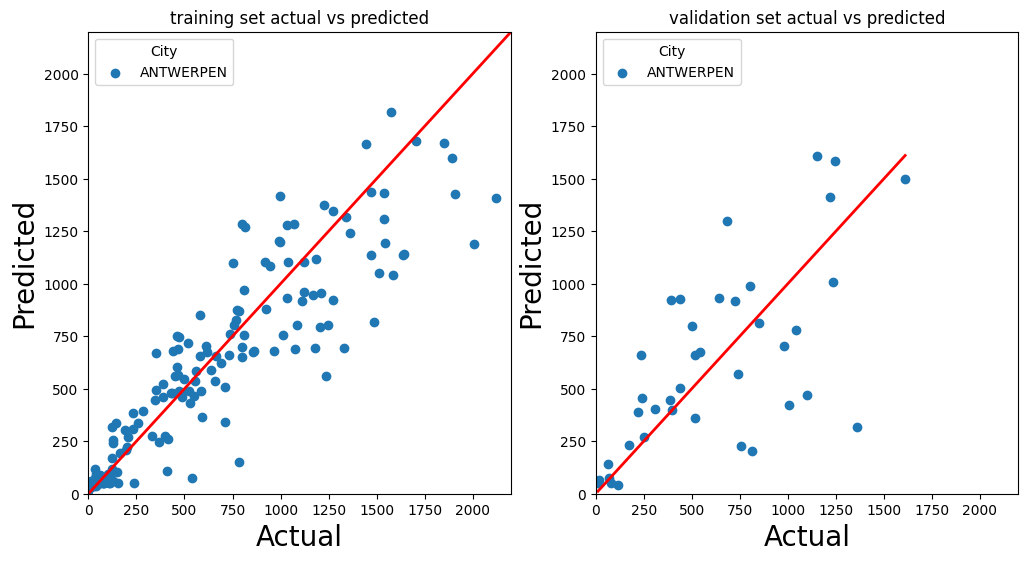

In [28]:
## Training and Validation

dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_val, label=y_val)
dtest = xgb.DMatrix(X_test)

model = xgb.XGBRegressor(objective='reg:squarederror', eval_metric='rmse') #training loss is based on the squared error of the loss, the evaluation metric of the validation set is rmse

#CROSS VALIDATION
if setup_params['CV'] == 0:
    model = xgb.XGBRegressor(colsample_bytree= 0.4, learning_rate= 0.1, max_depth=4, min_child_weight=6, n_estimators= 40, subsample= 0.7) 
    model.fit(X_train, y_train)

elif setup_params['CV'] == 1:
    param_grid = {
        'max_depth': [2, 3, 4],
        'learning_rate': [0.05, 0.1, 0.2],
        'n_estimators': [30, 40, 50],
        'min_child_weight': [4, 5, 6],
        'subsample': [0.6, 0.7, 0.8],
        'colsample_bytree': [0.4, 0.5, 0.6],
        # 'reg_alpha': [0.05, 0.075, 0.1], regularization doesnt seem to help
        # 'reg_lambda' : [0.05, 0.075, 0.1]
    }

    # Initialize GridSearchCV with the defined parameter grid and XGBoost model, the scoring function wants to maximize so negative MSE is chosen
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=-1)

    # Perform GridSearchCV
    grid_search.fit(X_train, y_train)

    # Get the best parameters and the best score
    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print("Best Parameters:", best_params)
    print("Best Score (MSE):", -best_score)

    # Evaluate the model on the validation data
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_val)
    mse = metrics.mean_squared_error(y_val, y_pred)
    print("Test MSE:", mse)


best_xgb_model = xgb.XGBRegressor(**best_params)
best_xgb_model.fit(X_train, y_train)
model = best_xgb_model

model.save_model(name_model)


# get predictions on training set
y_pred_train = pd.DataFrame(model.predict(X_train))

# get predictions on validation set
y_pred_val = pd.DataFrame(model.predict(X_val))

# Backtransform
if setup_params['logtrans'] == 1:
    X_train = X_train.apply(lambda x: np.exp(x)-1)  # Adding 1 to avoid log(0)
    X_val = X_val.apply(lambda x: np.exp(x)-1)  # Adding 1 to avoid log(0)

    y_train = y_train.apply(lambda x: np.exp(x)-1)  # Adding 1 to avoid log(0)
    y_val = y_val.apply(lambda x: np.exp(x)-1)  # Adding 1 to avoid log(0)

    y_pred_train = y_pred_train.apply(lambda x: np.exp(x)-1)
    y_pred_val = y_pred_val.apply(lambda x: np.exp(x)-1)
else:
    print("no log transfromation has been done")


# Training plot
cities = X_train_with_all_columns['city'].unique()
city_to_color = {city: plt.cm.tab20(i) for i, city in enumerate(cities)}  # Using tab20 colormap for distinct colors

plt.figure(figsize=(12, 6))

# Scatter plot with colors based on city
plt.subplot(1, 2, 1)
for city in cities:
    mask = X_train_with_all_columns['city'] == city
    y_train_city = y_train[mask.to_numpy()]
    y_pred_train_city = y_pred_train[mask.to_numpy()]
    plt.scatter(y_train_city, y_pred_train_city, label=city, color=city_to_color[city])

plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color="r", linestyle="-", linewidth=2)
plt.title("training set actual vs predicted")
plt.ylabel("Predicted", size=20)
plt.xlabel("Actual", size=20)
plt.xlim(0, 2200)  # Set x-axis limit
plt.ylim(0, 2200)  # Set y-axis limit
plt.legend(title='City', loc='upper left')


# Validation plot

plt.subplot(1, 2, 2)
for city in cities:
    mask = X_val_with_all_columns['city'] == city
    y_val_city = y_val[mask.to_numpy()]
    y_pred_val_city = y_pred_val[mask.to_numpy()]
    plt.scatter(y_val_city, y_pred_val_city, label=city, color=city_to_color[city])

plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color="r", linestyle="-", linewidth=2)
plt.title("validation set actual vs predicted")
plt.ylabel("Predicted", size=20)
plt.xlabel("Actual", size=20)
plt.xlim(0, 2200)  # Set x-axis limit
plt.ylim(0, 2200)  # Set y-axis limit
plt.legend(title='City', loc='upper left')

plt.show()

The graphs above show the predictions of the training set and the validation set.  These graphs show a decent fit until the true values are higher than 1500, then the model continuously underestimates the number of trips.


In the graph below the axis are limited to 500. This allows to check the predictions for zones with a low number of trips. Here it shows that a siginificant amount of predicted values are around 50. These are instances with almost no POI's and no inhabitants. 

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


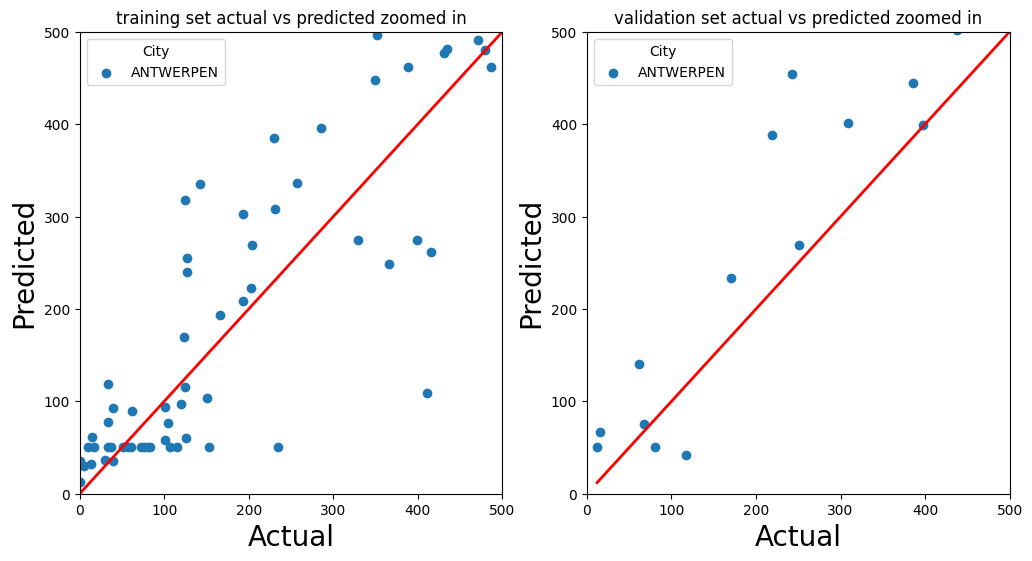

In [29]:
# Scatter plots with colors based on city
plt.figure(figsize=(12, 6))


#training plot

cities = X_train_with_all_columns['city'].unique()
city_to_color = {city: plt.cm.tab20(i) for i, city in enumerate(cities)}  # Using tab20 colormap for distinct colors

plt.subplot(1, 2, 1)
y_train_cities = []        # Store the results per city so that they can be used later
y_pred_train_cities = []   # Store the results per city so that they can be used later
cities_train = cities.copy()    # Store the cities so that the order is known

for city in cities:
    mask = X_train_with_all_columns['city'] == city
    y_train_city = y_train[mask.to_numpy()]
    y_pred_train_city = y_pred_train[mask.to_numpy()]
    y_train_cities.append(y_train_city)
    y_pred_train_cities.append(y_pred_train_city)
    plt.scatter(y_train_city, y_pred_train_city, label=city, color=city_to_color[city])

plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], color="r", linestyle="-", linewidth=2)
plt.title("training set actual vs predicted zoomed in")
plt.ylabel("Predicted", size=20)
plt.xlabel("Actual", size=20)
plt.xlim(0, 500)  # Set x-axis limit
plt.ylim(0, 500)  # Set y-axis limit
plt.legend(title='City', loc='upper left')


#validation plot
plt.subplot(1, 2, 2)
y_val_cities = []
y_pred_val_city = []
cities_val = cities.copy()

for city in cities:
    mask = X_val_with_all_columns['city'] == city
    y_val_city = y_val[mask.to_numpy()]
    y_pred_val_city = y_pred_val[mask.to_numpy()]
    y_val_cities.append(y_val_city)
    y_pred_val_city.append(y_pred_val_city )
    plt.scatter(y_val_city, y_pred_val_city, label=city, color=city_to_color[city])

plt.plot([min(y_val), max(y_val)], [min(y_val), max(y_val)], color="r", linestyle="-", linewidth=2)
plt.title("validation set actual vs predicted zoomed in")
plt.ylabel("Predicted", size=20)
plt.xlabel("Actual", size=20)
plt.xlim(0, 500)  # Set x-axis limit
plt.ylim(0, 500)  # Set y-axis limit
plt.legend(title='City', loc='upper left')

plt.show()

## Metrics overview TRAIN

In [30]:
# The metrics for all the observations in the training data are calculated
df_metrics_overview_train = metrics_overview(y_train,y_pred_train[0], False)  # If you want to see the output here, change False to True

divide by zero encountered in scalar divide


In [31]:
# Metrics overview per city
dfs_metrics_overview_train_cities = [df_metrics_overview_train]  # Is used to store all the information of the metrics of the training data

# The metrics per city in the training data are calculated
for city, y_train_city, y_pred_train_city in zip(cities_train, y_train_cities, y_pred_train_cities):
    df_metrics_overview_train_city = metrics_overview(y_train_city, y_pred_train_city[0], False)   # If you want to see the output here, change False to True
    dfs_metrics_overview_train_cities.append(df_metrics_overview_train_city)

divide by zero encountered in scalar divide


In [32]:
# Write the results of the metrics to excel
name_tables = ['ALL TOGHETER'] + list(cities_train)
name_excel_file = name_excel_file_metrics + '_TRAIN.xlsx'
write_metrics_overviews_to_excel(name_excel_file, 'TRAIN', dfs_metrics_overview_train_cities, name_tables)

## Model on test data

The following part will use the trained model to predict the number of trips in the test set. The graphs below show similar behaviour as in the training set. Here, the overestimation for very low values is more evident, as well as the values above 1500.

attraction


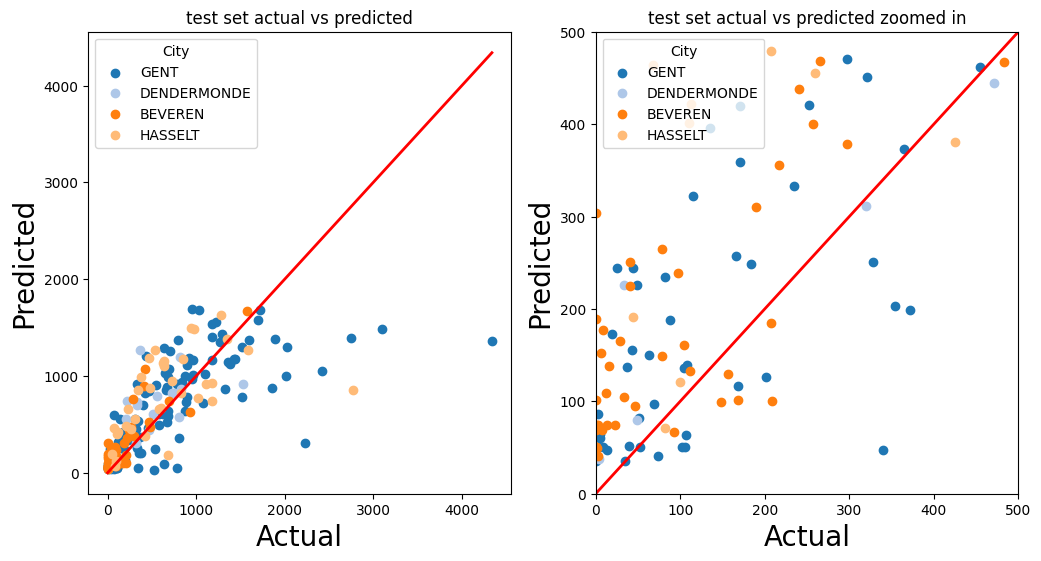

In [33]:
print(setup_params['target'])

model = xgb.XGBRegressor()
model.load_model(name_model) #If you have the trained model saved as a .json file, you can immediatly load it in here and make predictions on the test set. 

# get predictions on validation set
y_pred_test = pd.DataFrame(model.predict(X_test))

#Backtransform
if setup_params['logtrans'] == 1:
    X_test = X_test.apply(lambda x: np.exp(x)-1)  # Adding 1 to avoid log(0)
    y_pred_test = y_pred_test.apply(lambda x: np.exp(x)-1)
else:
    print("no log transfromation has been done")
    

#test plot
cities = X_test_with_all_columns['city'].unique()
city_to_color = {city: plt.cm.tab20(i) for i, city in enumerate(cities)}  # Using tab20 colormap for distinct colors
plt.figure(figsize = (12,6))
plt.subplot(1, 2, 1)
y_test_cities = []              # Store the results per city so that they can be used later
y_pred_test_cities = []         # Store the results per city so that they can be used later
cities_test = cities.copy()     # Store the cities so that the order is known


for city in cities:
    mask = X_test_with_all_columns['city'] == city
    y_test_city = y_test[mask.to_numpy()]
    y_pred_test_city = y_pred_test[mask.to_numpy()]
    y_test_cities.append(y_test_city)
    y_pred_test_cities.append(y_pred_test_city)
    plt.scatter(y_test_city, y_pred_test_city, label=city, color=city_to_color[city])

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="r", linestyle="-", linewidth=2)
plt.title("test set actual vs predicted")
plt.ylabel("Predicted", size=20)
plt.xlabel("Actual", size=20)
plt.legend(title='City', loc='upper left')

plt.subplot(1, 2, 2)
for city in cities:
    mask = X_test_with_all_columns['city'] == city
    y_test_city = y_test[mask.to_numpy()]
    y_pred_test_city = y_pred_test[mask.to_numpy()]
    plt.scatter(y_test_city, y_pred_test_city, label=city, color=city_to_color[city])

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="r", linestyle="-", linewidth=2)
plt.title("test set actual vs predicted zoomed in")
plt.ylabel("Predicted", size=20)
plt.xlabel("Actual", size=20)
plt.xlim(0, 500)  # Set x-axis limit
plt.ylim(0, 500)  # Set y-axis limit
plt.legend(title='City', loc='upper left')

plt.show()

## Metrics overview TEST

In [34]:
# The metrics for all the observations in the test data are calculated

df_metrics_test = metrics_overview(y_test,y_pred_test[0], False)    # If you want to see the output here, change False to True

In [35]:
# Metrics overview per city

dfs_metrics_overview_test_cities = [df_metrics_test] # Is used to store all the information of the metrics of the training data

# The metrics per city in the training data are calculated
for city, y_test_city, y_pred_test_city in zip(cities_test, y_test_cities, y_pred_test_cities):
    df_metrics_overview_test_city = metrics_overview(y_test_city, y_pred_test_city[0], False)   # If you want to see the output here, change False to True
    dfs_metrics_overview_test_cities.append(df_metrics_overview_test_city)

divide by zero encountered in scalar divide
divide by zero encountered in scalar divide
divide by zero encountered in scalar divide
divide by zero encountered in scalar divide
divide by zero encountered in scalar divide
divide by zero encountered in scalar divide


In [36]:
# Write the results to excel
name_tables = ['ALL TOGHETER'] + list(cities_test)
name_excel_file = name_excel_file_metrics + '_TEST.xlsx'
write_metrics_overviews_to_excel(name_excel_file, 'TEST', dfs_metrics_overview_test_cities, name_tables)

# Interpretation of the results

Discussions of the results will be limited an very similar to the full model in the following parts. These plots and interpretations are created to support the discussions of the research questions. 

## SHAP

The interpretation starts with an analysis of the shapley values. The shapley values of the test set will be used. However the code can also handle the training set.

In [37]:
# Specify which model and which datasets of points you want to analyse with the SHAP values
X_shap = X_test  # X_val, ...

explainer = shap.Explainer(model)
shap_values = explainer(X_shap)

print(setup_params['target'])
print(explainer.expected_value)

attraction
5.962822


### Summary plot

In a summary plot, features are ranked according to their average absolute SHAP value. This indicates how much each feature contributes to a prediction.

So Inhabitant is the most import feature for the attraction model. Then there are a whole host of features that have a significantly lower impact. It's interesting to see that school, services and industry have a significant importance in the prediction. It's also logical for an attraction model in morning rush hour as these POI's are likely to play a big role in attraction at that time. 

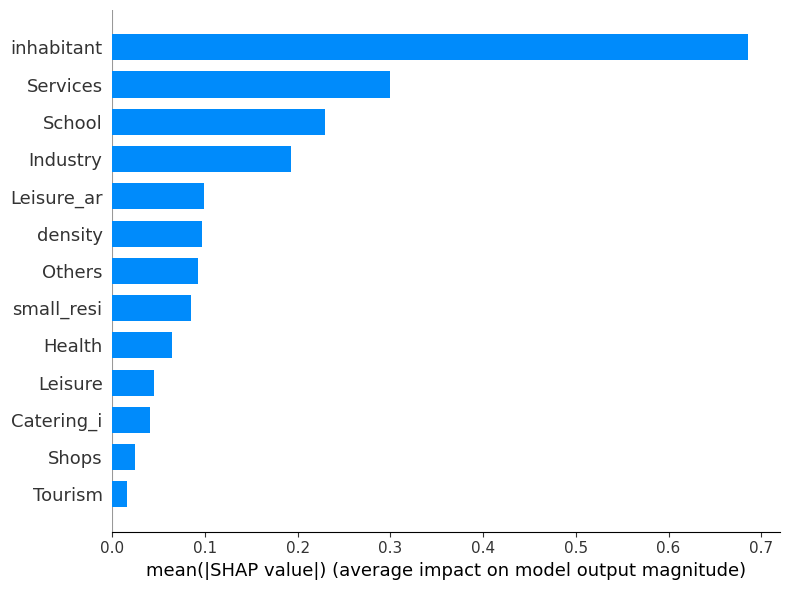

In [38]:
shap.summary_plot(shap_values, X_shap, plot_type="bar", plot_size=[8,6])

### Beeswarm plot

In contrast to the mean value in the summary plot, the beeswarm plots the values of the shap values of each observation for each feature. Moreover, the colour indicates the value for that particular feature for the observation.

For the features from inhabitant to industry, the beeswarm plot indicates that a high SHAP value always corresponds to a high value for that feature. This follows the intuition that a high value for any of these features leads to a high attraction. 

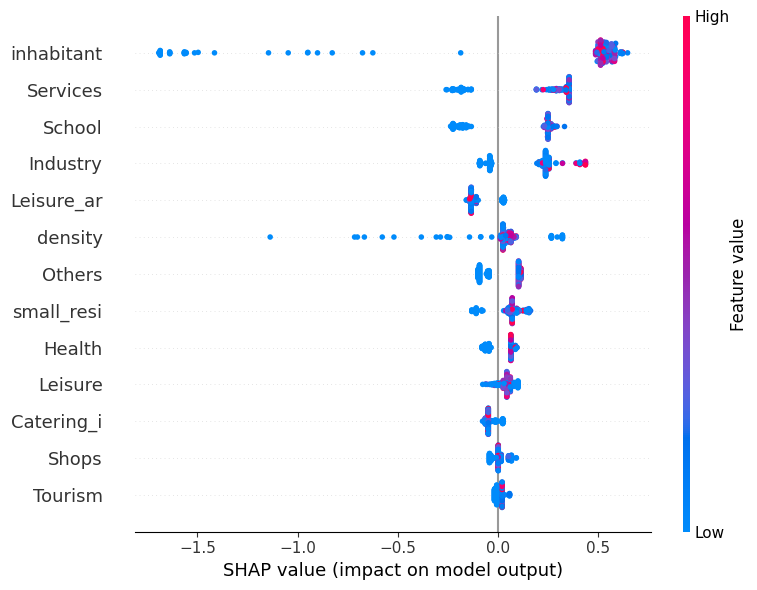

In [39]:
shap.summary_plot(shap_values, X_shap, plot_size=[8,6])

## Calculation absolute difference and percentage error per zone

In the following part the absolute difference and the percentage error between the real and the predicted values is calculated. Based on these values plots are made. Later these values will be used to analyze over and  underestimation. 

In [40]:
interest = 'test'  # 'train' is cities of the train data set, 'test' is the cities of the test dataset (has to be the same as X_shap)
print(interest)

if interest == 'train':
    # zones_plot = zones_city[zones_city["NIS_GEM_L"].str.contains("ANTWERPEN")]
    data_plot = pd.concat([X_train_with_all_columns, X_val_with_all_columns], ignore_index=True)  # Add X_train & X_val togheter and use this files so that the order is the same as in the real_values list

    pred_values_list_train = y_pred_train[0].values.flatten().tolist()
    pred_values_list_val = y_pred_val[0].values.flatten().tolist()
    pred_values_list = pred_values_list_train + pred_values_list_val
    real_values_list_train = y_train.tolist()
    real_values_list_val = y_val.tolist()
    real_values_list = real_values_list_train + real_values_list_val

elif interest == 'test':
    # zones_plot = zones_city[zones_city["NIS_GEM_L"].str.contains("GENT")]
    data_plot = data_test.copy()

    pred_values_list = y_pred_test.values.flatten().tolist()
    real_values_list = list(y_test)  

test


In [41]:
# Make the list with the difference between the predicted value and the 'real' value
result_difference = [x - y for x, y in zip(pred_values_list, real_values_list)]
percentage_error = [((x - y)/(y+1))*100 for x, y in zip(pred_values_list, real_values_list)]    # +1 so that there is no division by zero

## Plots

These plots are made per city:
- Attraction: values from attraction from the MOW, so not the model
- Absolute difference: absolute difference of outcome model vs values from MOW data
- Percentage difference: percentage difference of outcome model vs values from MOW data
- Filtered percentage difference: only the percentage difference that have an absolute difference bigger than the printed threshold


The colour bar of the absolute and percentage differences are fixed between [-100; 100] and [-500; 500], respectively. If the number of a zone is higher than the interval, the zone is coloured black and if it is lower than the interval, it is coloured yellow. A symmetrical interval is imposed so that the colours follow the intuition of white is neutral, red is negative and blue is positive. Working with fixed values for all cities ensures that cities can be easily compared with each other as this way the same colour means the same difference in each city. In addition, a very important reason for imposing these intervals is that if this is not done, little difference in colour can be observed. This is because in most cities there are a few extreme outliers. 

Cities are from:  test
Threshold for absolute value by filtering:  100
GENT


The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


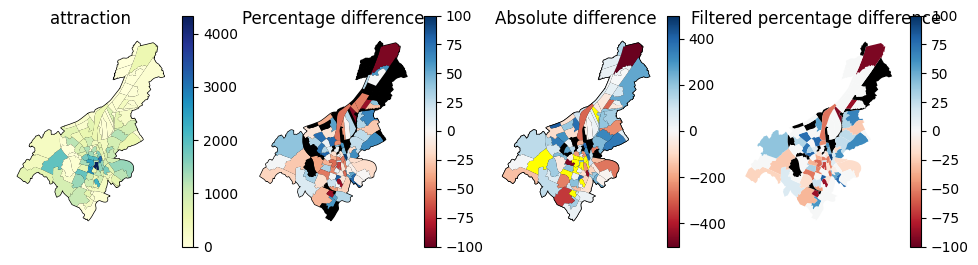

DENDERMONDE


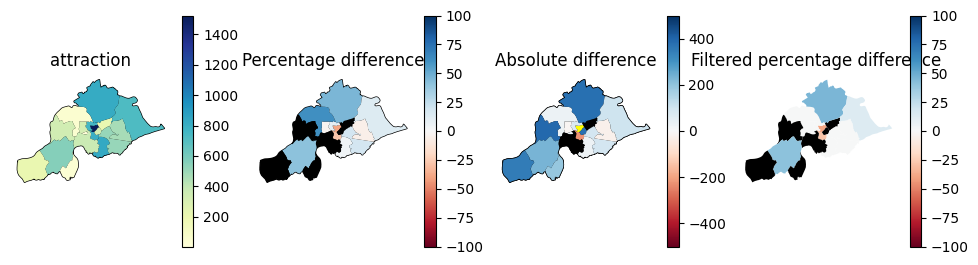

BEVEREN


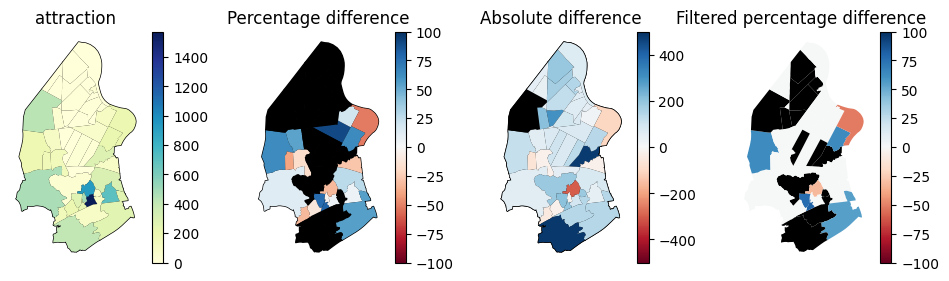

HASSELT


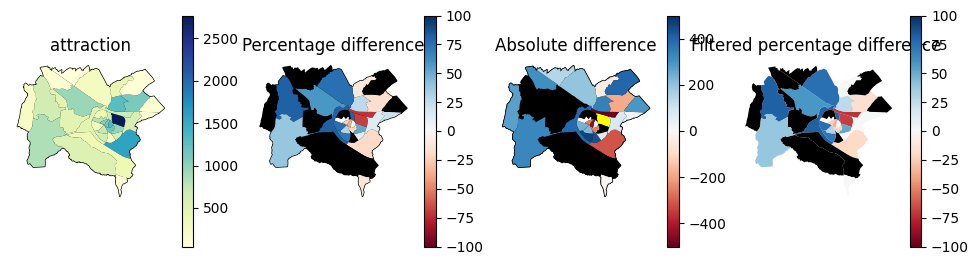

In [42]:
print('Cities are from: ', interest) 

threshold_filtering_absolute_value = 100  # Threshold 

print('Threshold for absolute value by filtering: ',threshold_filtering_absolute_value)

cities = data_plot['city'].unique()

cmap_adapted = plt.cm.get_cmap('RdBu')
cmap_adapted.set_over('black')  # Values above vmax (see later in subplot) will be plotted in black
cmap_adapted.set_under('yellow')  # Values below vmin (see later in subplot) will be plotted in yellow


# Iterate over each city and plot
for city in cities:
    print(city)
    city_data = data_plot[data_plot['city'] == city]

    # Extract the indices for the current city data
    indices = city_data.index

    # Create a filtering for the percentages with a min difference of absolute values
    adapted_percentages = []
    for i in indices:
        if abs(result_difference[i]) > threshold_filtering_absolute_value:
            adapted_percentages.append(percentage_error[i]) 
        else:
            adapted_percentages.append(0)  # So that this does not get a colour if the absolute difference is lower than the threshold

    fig, axes = plt.subplots(1, 4, figsize=(12, 3))

    # Plot the GeoPandas DataFrame for the current city in all subplots
    city_data.plot(ax=axes[0], color='lightgray', edgecolor='black')
    city_data.plot(ax=axes[1], color='lightgray', edgecolor='black')
    city_data.plot(ax=axes[2], color='lightgray', edgecolor='black')
    city_data.plot(ax=axes[2], color='lightgray', edgecolor='black')

    # Plot the values for attraction
    city_data.assign(values=data_plot[setup_params['target']]).plot(
        column='values', cmap='YlGnBu', linewidth=0, legend=True, ax=axes[0])
    axes[0].set_title(setup_params['target'])
    axes[0].set_axis_off()  # Remove the axes because these are the coordinates and does not provide added value

    # Plot the percentage difference 
    city_data.assign(values=[percentage_error[i] for i in indices]).plot(
        column='values', cmap= cmap_adapted, linewidth=0, legend=True, ax=axes[1], vmin = - 100, vmax = 100)
    axes[1].set_title(f'Percentage difference')
    axes[1].set_axis_off()  # Remove the axes because these are the coordinates and does not provide added value
    
    # Plot the absolute difference
    city_data.assign(values=[result_difference[i] for i in indices]).plot(
        column='values', cmap=cmap_adapted, linewidth=0, legend=True, ax=axes[2], vmin = - 500, vmax = 500)
    axes[2].set_title(f'Absolute difference')
    axes[2].set_axis_off()  # Remove the axes because these are the coordinates and does not provide added value

    # Plot the percentage difference where the condition is met
    city_data.assign(values=adapted_percentages).plot(
        column='values', cmap= cmap_adapted, linewidth=0, legend=True, ax=axes[3], vmin = - 100, vmax = 100)
    axes[3].set_title(f'Filtered percentage difference ')
    axes[3].set_axis_off()  # Remove the axes because these are the coordinates and does not provide added value
    

    # Show the plot
    plt.show()

The plots above show a clear pattern of great overestimation. Even the filtered plots show a lot of black zones. This is an indication that only training on Antwerp leads to worse results, certainly for the smaller cities

## Underestimation

The following part checks why some of the instances are underestimated. A zone is greatly underestimated when the percentage error is lower than -75%. In total 6 zones are underestimated. All of these zones are from Gent. 
<br>
Most of the underestimated zones are the same as in the full model and fall under the same cases that are discussed there.

In [44]:
#Underestimation 
indices = [index for index, value in enumerate(percentage_error) if (value <= -75)]
print(interest)
shap.initjs()

for indx in indices:
    zone_nr = data_plot.iloc[indx]['ZONENUMMER']
    print('\nZone number:', zone_nr)
    print("     Predicted value: ", pred_values_list[indx])
    print("     Real value: ", real_values_list[indx])
    print("     percentage error: ", percentage_error[indx])

    if interest == 'test':
        index = data_test.index[data_test['ZONENUMMER'] == zone_nr]
        print(data_test[data_test["ZONENUMMER"] == zone_nr].head())
        display(shap.force_plot(explainer.expected_value, shap_values.values[index,:], X_shap.iloc[index,:]))

    elif interest == 'train':
        index = data_train.index[data_train['ZONENUMMER'] == zone_nr]
        print(data_train[data_train["ZONENUMMER"] == zone_nr])
        display(shap.force_plot(explainer.expected_value, shap_values.values[index,:], X_shap.iloc[index,:]))

        
print("number of hits: ", len(indices))
## ATTRACTION
# zone 2500/2505/2507/2550 : Low inhabitants cause underestimation
# zone 2525/2531: high real value but no POI's and no inhabitants, No POI's actually decrease the prediction, this was not necessary here
# zone 2577: No POI's actually decrease the prediction, this was not necessary here
# Also remarkable that all of these are from Gent and not from the smaller cities

## PRODUCTION
# Almost everything here depends on the nr of inhabitants: if this doenst correspond than the prediction is bad
# interesting relation between density and inhabitants


test



Zone number: 2505
     Predicted value:  308.699462890625
     Real value:  2223.5040000000004
     percentage error:  -86.07781946489533
   ZONENUMMER  inhabitant     density  city  city_size  production  \
38       2505  383.442156  794.262376  GENT     270000     131.502   

    attraction  large_resi  small_resi      School        Health     Leisure  \
38    2223.504         0.0  3508.21136  9762.93336  84135.815336  718.986467   

        Shops     Services  Industry  Catering_i  Tourism       Others  \
38  901.77029  1192.356578       0.0   403.61308      0.0  2286.867772   

      Leisure_ar                                           geometry  
38  42630.986278  POLYGON ((104568.578 190789.164, 104596.036 19...  



Zone number: 2520
     Predicted value:  46.832828521728516
     Real value:  339.978
     percentage error:  -85.97187251912777
   ZONENUMMER  inhabitant   density  city  city_size  production  attraction  \
53       2520    0.147875  0.174431  GENT     270000      30.976     339.978   

    large_resi  small_resi  School  Health  Leisure  Shops     Services  \
53         0.0         0.0     0.0     0.0      0.0    0.0  1921.396313   

         Industry  Catering_i  Tourism  Others  Leisure_ar  \
53  294888.747891  145.610865      0.0     0.0         0.0   

                                             geometry  
53  POLYGON ((108895.956 200918.701, 108255.699 20...  



Zone number: 2525
     Predicted value:  50.873355865478516
     Real value:  780.999
     percentage error:  -93.36657005117928
   ZONENUMMER  inhabitant  density  city  city_size  production  attraction  \
58       2525         0.0      0.0  GENT     270000        25.0     780.999   

    large_resi  small_resi  School  Health  Leisure  Shops  Services  \
58         0.0         0.0     0.0     0.0      0.0    0.0       0.0   

    Industry  Catering_i  Tourism  Others  Leisure_ar  \
58       0.0         0.0      0.0     0.0         0.0   

                                             geometry  
58  POLYGON ((106355.784 200453.284, 106360.153 20...  



Zone number: 2531
     Predicted value:  31.744667053222656
     Real value:  525.638
     percentage error:  -93.78231972375282
   ZONENUMMER  inhabitant   density  city  city_size  production  attraction  \
64       2531    0.732283  0.104383  GENT     270000      17.638     525.638   

    large_resi  small_resi  School  Health  Leisure  Shops  Services  \
64         0.0         0.0     0.0     0.0      0.0    0.0       0.0   

    Industry  Catering_i  Tourism  Others  Leisure_ar  \
64       0.0         0.0      0.0     0.0         0.0   

                                             geometry  
64  POLYGON ((109072.236 204556.156, 109049.418 20...  



Zone number: 2550
     Predicted value:  85.46800231933594
     Real value:  639.999
     percentage error:  -86.51043101169644
   ZONENUMMER  inhabitant     density  city  city_size  production  \
83       2550  104.233716  180.751702  GENT     270000        22.0   

    attraction  large_resi  small_resi        School  Health  Leisure  \
83     639.999         0.0         0.0  40094.025809     0.0      0.0   

         Shops      Services      Industry  Catering_i  Tourism  Others  \
83  184.372492  18500.234352  21720.013717  116.436537      0.0     0.0   

      Leisure_ar                                           geometry  
83  16155.641099  POLYGON ((103984.221 188637.886, 103893.983 18...  


number of hits:  5


## Overestimation

For the large overestimate, the zones examined are those where at least three times overestimated (200%) and there is a minimum overestimate of an absolute value of 100. The condition for a minimum absolute value of 100 is because for small absolute numbers, a difference is immediately a large percentage difference. 

There are 25 zones with a considered big overestimation. This is 19 more than in the full model. This shows that this model constantly overestimates. An increase in inhabitants or some POI feature lead to out of proportion increases of attracted trips. 

In [46]:
#Plot shapley values and force plots for overestimated instances
indices = [index for index, value in enumerate(percentage_error) if (value >= 200 and result_difference[index] > 100)]

print(interest)
shap.initjs()

for indx in indices:
    zone_nr = data_plot.iloc[indx]['ZONENUMMER']
    print('\nZone number:', zone_nr)
    print("     Predicted value: ", pred_values_list[indx])
    print("     Real value: ", real_values_list[indx])
    print("     percentage error: ", percentage_error[indx])

    if interest == 'test':
        index = data_test.index[data_test['ZONENUMMER'] == zone_nr]
        display(shap.force_plot(explainer.expected_value, shap_values.values[index,:], X_shap.iloc[index,:]))
        print(data_test[data_test["ZONENUMMER"] == zone_nr].head())

    elif interest == 'train':
        index = data_train.index[data_train['ZONENUMMER'] == zone_nr]
        display(shap.force_plot(explainer.expected_value, shap_values.values[index,:], X_shap.iloc[index,:]))
        print(data_train[data_train["ZONENUMMER"] == zone_nr])

        
print("number of hits: ", len(indices))
## PRODUCTION
# percentage error are much lower than attraction
# low production zones are mostly predicted pretty well (high percentage error but very low absolute difference)

test



Zone number: 2487
     Predicted value:  244.71803283691406
     Real value:  25.336
     percentage error:  833.0119715860952


   ZONENUMMER  inhabitant      density  city  city_size  production  \
20       2487  712.570539  1268.101516  GENT     270000     123.336   

    attraction   large_resi    small_resi  School  Health  Leisure  Shops  \
20      25.336  2418.571185  12092.043651     0.0     0.0      0.0    0.0   

      Services    Industry  Catering_i  Tourism  Others   Leisure_ar  \
20  680.646845  262.901445         0.0      0.0     0.0  3164.397074   

                                             geometry  
20  POLYGON ((102202.920 194394.694, 102228.315 19...  

Zone number: 2499
     Predicted value:  596.166015625
     Real value:  69.815
     percentage error:  743.2761641248322


   ZONENUMMER   inhabitant     density  city  city_size  production  \
32       2499  1065.914662  4435.71459  GENT     270000     157.816   

    attraction    large_resi  small_resi      School      Health     Leisure  \
32      69.815  16828.229874  473.673984  990.957146  984.879414  262.314971   

    Shops      Services     Industry  Catering_i  Tourism       Others  \
32    0.0  17944.870175  1160.786737  228.382715      0.0  1749.390295   

      Leisure_ar                                           geometry  
32  55591.922218  POLYGON ((104434.123 195096.747, 104427.548 19...  

Zone number: 2519
     Predicted value:  244.3203582763672
     Real value:  43.830999999999996
     percentage error:  447.21143466879437


   ZONENUMMER  inhabitant     density  city  city_size  production  \
52       2519  601.573275  479.553725  GENT     270000      74.832   

    attraction  large_resi   small_resi  School  Health  Leisure  Shops  \
52      43.831         0.0  3773.395073     0.0     0.0      0.0    0.0   

    Services    Industry  Catering_i  Tourism  Others  Leisure_ar  \
52       0.0  1906.84308         0.0      0.0     0.0         0.0   

                                             geometry  
52  POLYGON ((110185.388 200300.653, 110258.996 20...  

Zone number: 2548
     Predicted value:  155.5161590576172
     Real value:  43.346999999999994
     percentage error:  252.93516823599614


   ZONENUMMER  inhabitant      density  city  city_size  production  \
81       2548  477.804363  4715.240271  GENT     270000      94.349   

    attraction  large_resi    small_resi  School  Health  Leisure  Shops  \
81      43.347         0.0  20465.969203     0.0     0.0      0.0    0.0   

    Services    Industry  Catering_i  Tourism  Others  Leisure_ar  \
81       0.0  190.842126         0.0      0.0     0.0         0.0   

                                             geometry  
81  POLYGON ((104471.636 189335.298, 104450.366 18...  

Zone number: 2553
     Predicted value:  137.13333129882812
     Real value:  36.742
     percentage error:  265.9936709735259


   ZONENUMMER  inhabitant     density  city  city_size  production  \
86       2553  362.724735  703.496961  GENT     270000      45.742   

    attraction  large_resi    small_resi        School  Health      Leisure  \
86      36.742   1839.5031  19845.583955  10527.886447     0.0  1282.453866   

    Shops    Services  Industry  Catering_i     Tourism      Others  \
86    0.0  685.884344       0.0         0.0  321.292008  412.877516   

       Leisure_ar                                           geometry  
86  145326.824396  POLYGON ((103527.616 190059.524, 103552.109 19...  

Zone number: 2562
     Predicted value:  225.3710479736328
     Real value:  48.369
     percentage error:  358.5287285009476


   ZONENUMMER  inhabitant     density  city  city_size  production  \
95       2562  784.364021  313.806295  GENT     270000      120.37   

    attraction  large_resi    small_resi  School  Health  Leisure       Shops  \
95      48.369         0.0  56164.644569     0.0     0.0      0.0  101.166718   

      Services    Industry  Catering_i  Tourism  Others  Leisure_ar  \
95  574.955645  339.257038   289.85968      0.0     0.0         0.0   

                                             geometry  
95  POLYGON ((100509.149 192316.509, 100465.835 19...  

Zone number: 2566
     Predicted value:  558.8314208984375
     Real value:  141.79500000000002
     percentage error:  292.0525374827112


   ZONENUMMER  inhabitant    density  city  city_size  production  attraction  \
99       2566   14.837409  27.171535  GENT     270000      13.794     141.795   

    large_resi   small_resi        School       Health      Leisure  \
99  559.382821  1071.507426  12856.683706  1067.968608  1765.189854   

          Shops      Services      Industry  Catering_i  Tourism  Others  \
99  24956.60363  11506.993781  96161.859916   54.464053      0.0     0.0   

     Leisure_ar                                           geometry  
99  9488.204083  POLYGON ((102240.691 197955.234, 102228.444 19...  

Zone number: 2582
     Predicted value:  172.39578247070312
     Real value:  19.0
     percentage error:  766.9789123535156


    ZONENUMMER  inhabitant    density  city  city_size  production  \
115       2582   11.737479  12.663493  GENT     270000         3.0   

     attraction  large_resi  small_resi  School  Health  Leisure  Shops  \
115        19.0         0.0         0.0     0.0     0.0      0.0    0.0   

     Services  Industry  Catering_i  Tourism  Others  Leisure_ar  \
115       0.0       0.0         0.0      0.0     0.0         0.0   

                                              geometry  
115  POLYGON ((109905.649 206953.526, 109729.814 20...  

Zone number: 2297
     Predicted value:  736.5647583007812
     Real value:  216.84300000000002
     percentage error:  238.57629499262364


    ZONENUMMER   inhabitant      density         city  city_size  production  \
120       2297  1564.644843  1697.053672  DENDERMONDE      50000     330.843   

     attraction   large_resi    small_resi  School      Health      Leisure  \
120     216.843  1622.453577  53856.836884     0.0  173.218188  3039.235221   

            Shops     Services     Industry   Catering_i  Tourism      Others  \
120  32809.525025  6612.976844  1736.807954  1655.751036      0.0  837.868577   

     Leisure_ar                                           geometry  
120  694.739287  POLYGON ((132573.863 191408.584, 132516.626 19...  

Zone number: 2304
     Predicted value:  1267.1387939453125
     Real value:  360.844
     percentage error:  250.4656133431292


    ZONENUMMER   inhabitant      density         city  city_size  production  \
127       2304  3097.205356  1012.362014  DENDERMONDE      50000     686.845   

     attraction  large_resi     small_resi       School       Health  \
127     360.844  4046.22482  154182.780405  5031.149254  2345.501878   

         Leisure  Shops      Services     Industry  Catering_i  Tourism  \
127  6770.819947    0.0  19735.909982  74205.30563  382.342541      0.0   

          Others     Leisure_ar  \
127  1060.647732  345407.699012   

                                              geometry  
127  POLYGON ((130745.251 188970.865, 130704.644 18...  

Zone number: 2309
     Predicted value:  225.3710479736328
     Real value:  33.735
     percentage error:  551.7087893295892


    ZONENUMMER  inhabitant     density         city  city_size  production  \
132       2309  528.935957  246.988169  DENDERMONDE      50000      94.734   

     attraction  large_resi    small_resi  School  Health  Leisure  \
132      33.735         0.0  45974.078484     0.0     0.0      0.0   

          Shops    Services  Industry  Catering_i  Tourism      Others  \
132  633.913818  706.331209       0.0   270.38921      0.0  312.320942   

     Leisure_ar                                           geometry  
132  681.514261  POLYGON ((129234.406 186747.783, 129194.057 18...  

Zone number: 2725
     Predicted value:  264.3965148925781
     Real value:  78.67
     percentage error:  233.1197626365986


    ZONENUMMER  inhabitant      density     city  city_size  production  \
136       2725  498.883892  1057.719353  BEVEREN      50000       70.67   

     attraction   large_resi    small_resi  School  Health  Leisure  \
136       78.67  5587.272108  27617.555429     0.0     0.0      0.0   

            Shops    Services      Industry  Catering_i  Tourism  Others  \
136  18271.627415  750.637821  58808.502906         0.0      0.0     0.0   

      Leisure_ar                                           geometry  
136  4241.733894  POLYGON ((142563.357 212027.747, 142597.260 21...  

Zone number: 2730
     Predicted value:  225.23875427246094
     Real value:  41.145
     percentage error:  436.81042655703146


    ZONENUMMER  inhabitant    density     city  city_size  production  \
141       2730  664.930769  98.935955  BEVEREN      50000     121.146   

     attraction  large_resi    small_resi  School  Health     Leisure  \
141      41.145         0.0  66194.671125     0.0     0.0  954.100816   

           Shops     Services    Industry  Catering_i    Tourism  Others  \
141  4042.690793  1128.877183  520.428821         0.0  152.68059     0.0   

      Leisure_ar                                           geometry  
141  20361.98731  POLYGON ((139759.399 210859.936, 139747.410 21...  

Zone number: 2739
     Predicted value:  304.2710266113281
     Real value:  0.0
     percentage error:  30427.102661132812


    ZONENUMMER  inhabitant   density     city  city_size  production  \
150       2739        11.0  6.755464  BEVEREN      50000         1.0   

     attraction  large_resi  small_resi  School  Health  Leisure  Shops  \
150         0.0         0.0   1712.5778     0.0     0.0      0.0    0.0   

     Services     Industry  Catering_i  Tourism  Others  Leisure_ar  \
150       0.0  7737.300077         0.0      0.0     0.0         0.0   

                                              geometry  
150  POLYGON ((139983.098 218736.745, 139941.290 21...  

Zone number: 2741
     Predicted value:  251.07269287109375
     Real value:  41.0
     percentage error:  500.17307826450894


    ZONENUMMER  inhabitant   density     city  city_size  production  \
152       2741   11.384716  6.123119  BEVEREN      50000        11.0   

     attraction  large_resi   small_resi  School  Health    Leisure  Shops  \
152        41.0         0.0  1459.040536     0.0     0.0  67.240515    0.0   

     Services    Industry  Catering_i  Tourism  Others  Leisure_ar  \
152       0.0  9777.71837         0.0      0.0     0.0         0.0   

                                              geometry  
152  POLYGON ((138728.124 218419.144, 138446.874 22...  

Zone number: 2747
     Predicted value:  137.90267944335938
     Real value:  16.0
     percentage error:  717.0745849609375


    ZONENUMMER  inhabitant   density     city  city_size  production  \
158       2747   24.407209  5.715416  BEVEREN      50000         4.0   

     attraction  large_resi   small_resi  School  Health  Leisure  Shops  \
158        16.0         0.0  3246.337351     0.0     0.0      0.0    0.0   

      Services  Industry  Catering_i  Tourism  Others  Leisure_ar  \
158  73.458398       0.0         0.0      0.0     0.0         0.0   

                                              geometry  
158  POLYGON ((141225.271 222847.820, 142238.862 22...  

Zone number: 2751
     Predicted value:  152.6578826904297
     Real value:  6.0
     percentage error:  2095.1126098632812


    ZONENUMMER  inhabitant   density     city  city_size  production  \
162       2751    5.630237  4.141503  BEVEREN      50000         1.0   

     attraction  large_resi  small_resi  School  Health  Leisure  Shops  \
162         6.0         0.0  4975.22159     0.0     0.0      0.0    0.0   

     Services     Industry  Catering_i  Tourism  Others  Leisure_ar  \
162       0.0  1795.171986         0.0      0.0     0.0         0.0   

                                              geometry  
162  POLYGON ((142238.862 221787.854, 141225.271 22...  

Zone number: 2753
     Predicted value:  177.25900268554688
     Real value:  8.875
     percentage error:  1705.1544575751582


    ZONENUMMER  inhabitant   density     city  city_size  production  \
164       2753   15.455947  5.198169  BEVEREN      50000       3.875   

     attraction  large_resi   small_resi  School  Health  Leisure  Shops  \
164       8.875         0.0  3300.067507     0.0     0.0      0.0    0.0   

     Services    Industry  Catering_i  Tourism  Others  Leisure_ar  \
164       0.0  729.850508         0.0      0.0     0.0         0.0   

                                              geometry  
164  POLYGON ((141979.624 223580.743, 141225.271 22...  

Zone number: 2754
     Predicted value:  189.39215087890625
     Real value:  0.0
     percentage error:  18939.215087890625


    ZONENUMMER  inhabitant   density     city  city_size  production  \
165       2754        43.0  8.615559  BEVEREN      50000         3.0   

     attraction  large_resi   small_resi  School  Health  Leisure  Shops  \
165         0.0         0.0  6214.709535     0.0     0.0      0.0    0.0   

     Services  Industry  Catering_i     Tourism  Others  Leisure_ar  \
165       0.0       0.0         0.0  605.348353     0.0         0.0   

                                              geometry  
165  POLYGON ((139473.171 223499.364, 139476.171 22...  

Zone number: 2763
     Predicted value:  101.80191040039062
     Real value:  0.0
     percentage error:  10180.191040039062


    ZONENUMMER  inhabitant  density     city  city_size  production  \
174       2763         0.0      0.0  BEVEREN      50000         1.0   

     attraction  large_resi  small_resi  School  Health  Leisure  Shops  \
174         0.0         0.0   13.797686     0.0     0.0      0.0    0.0   

        Services      Industry  Catering_i  Tourism  Others  Leisure_ar  \
174  1554.834119  316883.27784         0.0      0.0     0.0         0.0   

                                              geometry  
174  POLYGON ((141405.543 217987.033, 139771.403 21...  

Zone number: 2764
     Predicted value:  165.68185424804688
     Real value:  29.0
     percentage error:  455.6061808268229


    ZONENUMMER  inhabitant   density     city  city_size  production  \
175       2764         6.0  2.889866  BEVEREN      50000         0.0   

     attraction  large_resi  small_resi  School  Health  Leisure  Shops  \
175        29.0         0.0     17.9612     0.0     0.0      0.0    0.0   

       Services       Industry  Catering_i  Tourism  Others  Leisure_ar  \
175  155.903915  175746.522731         0.0      0.0     0.0         0.0   

                                              geometry  
175  POLYGON ((141034.593 214771.245, 142464.313 21...  

Zone number: 2945
     Predicted value:  401.3524169921875
     Real value:  110.757
     percentage error:  260.0243537247667


    ZONENUMMER   inhabitant     density     city  city_size  production  \
202       2945  1122.428841  484.462265  HASSELT      80000      226.76   

     attraction  large_resi     small_resi      School  Health      Leisure  \
202     110.757         0.0  102426.859157  269.201516     0.0  3318.359414   

            Shops     Services  Industry  Catering_i  Tourism  Others  \
202  10939.136131  4526.506323       0.0         0.0      0.0     0.0   

       Leisure_ar                                           geometry  
202  11344.211803  POLYGON ((222790.885 182824.744, 222866.041 18...  

Zone number: 2949
     Predicted value:  464.1376953125
     Real value:  67.21900000000001
     percentage error:  581.830128428297


    ZONENUMMER  inhabitant     density     city  city_size  production  \
206       2949  982.706346  212.277589  HASSELT      80000     201.222   

     attraction  large_resi    small_resi       School  Health      Leisure  \
206      67.219         0.0  81184.570642  2952.158948     0.0  11089.32967   

     Shops     Services     Industry  Catering_i      Tourism  Others  \
206    0.0  3993.185545  2475.445798   837.02769  1371.004192     0.0   

        Leisure_ar                                           geometry  
206  176271.371839  POLYGON ((221617.273 185778.496, 221652.724 18...  

Zone number: 2955
     Predicted value:  421.3092041015625
     Real value:  112.721
     percentage error:  271.355514022531


    ZONENUMMER   inhabitant   density     city  city_size  production  \
212       2955  1264.834969  364.7274  HASSELT      80000     227.721   

     attraction  large_resi    small_resi       School      Health  Leisure  \
212     112.721         0.0  95482.962751  2177.700542  344.657889      0.0   

          Shops     Services     Industry   Catering_i     Tourism  \
212  1881.06298  1993.835545  1036.607526  1450.929891  516.814203   

         Others  Leisure_ar                                           geometry  
212  385.950963   88.491147  POLYGON ((213412.304 185139.481, 213495.452 18...  

Zone number: 2956
     Predicted value:  191.78924560546875
     Real value:  44.547
     percentage error:  323.27539817214915


    ZONENUMMER  inhabitant     density     city  city_size  production  \
213       2956  675.347395  234.058153  HASSELT      80000     136.546   

     attraction  large_resi    small_resi  School      Health   Leisure  \
213      44.547         0.0  53941.331644     0.0  113.632006  157.3155   

          Shops  Services     Industry  Catering_i     Tourism  Others  \
213  327.571476       0.0  2199.457617  497.034163  318.288368     0.0   

      Leisure_ar                                           geometry  
213  5719.541643  POLYGON ((214788.952 184142.221, 214765.361 18...  
number of hits:  25
